# Evaluation of Finetuned TB X-ray Classification Model


In [1]:
# Setup and Import Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

sys.path.append('..')
from attention_model import SimpleAttentionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Model Paths and Loading

In [2]:
# Define paths
ORIGINAL_MODEL_PATH = "../model/tb_chest_xray_attention_best.pt"
FINETUNED_MODEL_PATH = "../finetuning/tb_chest_xray_refined_20250318_034728.pt"
TEST_DATA_PATH = "../model/tuberculosis-dataset"  # Path to entire dataset directory
FEEDBACK_DATA_PATH = "../feedback/images"  # Feedback data
NEW_TEST_DATA_PATH = "../Testing/test_dataset/Chest-X-Ray/image"  # Any new test data, if available

# Check if the files and directories exist
print(f"Original model exists: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"Finetuned model exists: {os.path.exists(FINETUNED_MODEL_PATH)}")
print(f"Dataset directory exists: {os.path.exists(TEST_DATA_PATH)}")
print(f"Feedback data exists: {os.path.exists(FEEDBACK_DATA_PATH)}")

# Load the models
def load_model(model_path):
    model = SimpleAttentionCNN().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Load both models
original_model = load_model(ORIGINAL_MODEL_PATH)
finetuned_model = load_model(FINETUNED_MODEL_PATH)

# Set both models to evaluation mode
if original_model:
    original_model.eval()
if finetuned_model:
    finetuned_model.eval()

# Print available directories in the dataset folder to help with navigation
if os.path.exists(TEST_DATA_PATH):
    print(f"\nAvailable directories in dataset folder:")
    for item in os.listdir(TEST_DATA_PATH):
        if os.path.isdir(os.path.join(TEST_DATA_PATH, item)):
            print(f"  - {item}")

Original model exists: True
Finetuned model exists: True
Dataset directory exists: True
Feedback data exists: True


C:\Users\dell\AppData\Local\Temp\ipykernel_12700\942902260.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Successfully loaded model from ../model/tb_chest_xray_attention_best.pt
Successfully loaded model from ../finetuning/tb_chest_xray_refined_20250318_034728.pt

Available directories in dataset folder:
  - Normal
  - Tuberculosis


## 2. Dataset Loading

We'll create a dataset class to load and preprocess the X-ray images. We'll use this class to load:
1. Original test dataset
2. Feedback dataset
3. Any new test data (if available)

This will allow us to comprehensively evaluate the model on different data sources.

In [3]:
class TBXrayTestDataset(Dataset):
    """Dataset that loads X-ray images for evaluation."""
    def __init__(self, base_dir, transform=None, dataset_type='original'):
        self.dataset_type = dataset_type
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
        
        self.filepaths = []
        self.labels = []
        
        if dataset_type == 'original' or dataset_type == 'new':
            # Load normal images (label 0)
            normal_dir = os.path.join(base_dir, "Normal")
            if os.path.isdir(normal_dir):
                for filename in os.listdir(normal_dir):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        path = os.path.join(normal_dir, filename)
                        if os.path.isfile(path):
                            self.filepaths.append(path)
                            self.labels.append(0)
            
            # Load TB images (label 1)
            tb_dir = os.path.join(base_dir, "Tuberculosis")
            if os.path.isdir(tb_dir):
                for filename in os.listdir(tb_dir):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        path = os.path.join(tb_dir, filename)
                        if os.path.isfile(path):
                            self.filepaths.append(path)
                            self.labels.append(1)
        
        elif dataset_type == 'feedback':
            # For feedback data, try to load from feedback_log.csv
            feedback_csv = os.path.join(os.path.dirname(base_dir), "feedback_log.csv")
            if os.path.exists(feedback_csv):
                try:
                    df = pd.read_csv(feedback_csv)
                    for _, row in df.iterrows():
                        img_file = row.get('image_filename') or row.get('image_path')
                        label_str = row.get('label') or row.get('correct_label')
                        
                        if img_file and label_str:
                            img_path = os.path.join(base_dir, os.path.basename(img_file))
                            if os.path.isfile(img_path):
                                label = 1 if label_str.lower() == 'tb' else 0
                                self.filepaths.append(img_path)
                                self.labels.append(label)
                except Exception as e:
                    print(f"Error loading feedback data: {e}")
            else:
                # If no CSV, just load all images and guess labels from filenames
                for filename in os.listdir(base_dir):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        path = os.path.join(base_dir, filename)
                        # Try to guess label from filename
                        label = 1 if 'tb' in filename.lower() else 0
                        self.filepaths.append(path)
                        self.labels.append(label)
        
        print(f"Loaded {len(self.filepaths)} images from {dataset_type} dataset")
        print(f"Class distribution: {self.labels.count(0)} Normal, {self.labels.count(1)} TB")
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        
        # Read image
        try:
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                raise FileNotFoundError(f"Could not read image: {img_path}")
            
            # Convert to PIL for transforms
            pil_img = Image.fromarray(img_gray, mode='L')
            img_tensor = self.transform(pil_img)
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), img_path
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Return empty tensor with same shape
            return torch.zeros(1, 256, 256), torch.tensor(label, dtype=torch.float32), img_path

## 3. Create Test Datasets from CSV Files

Using the provided CSV files, we'll create three test datasets:
1. Original dataset from tuberculosis-CNN-model.ipynb
2. Feedback dataset from feedback_log.csv
3. New test dataset from MetaData.csv

In [4]:
# 1. Load the original dataset from TB-CNN model structure
DATASET_DIR = "../model/tuberculosis-dataset"
NORMAL_DIR = os.path.join(DATASET_DIR, "Normal")
TB_DIR = os.path.join(DATASET_DIR, "Tuberculosis")

# Create a function to extract test set from the original dataset structure
def load_original_test_set(test_split=0.3, random_seed=42):
    all_images = []
    all_labels = []
    all_paths = []

    # Check if the directories exist
    if not os.path.isdir(NORMAL_DIR) or not os.path.isdir(TB_DIR):
        print(f"Original dataset directories not found: {NORMAL_DIR}, {TB_DIR}")
        return None, None, None

    # Load Normal images (label = 0)
    for fname in os.listdir(NORMAL_DIR):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(NORMAL_DIR, fname)
            all_paths.append(filepath)
            all_labels.append(0)

    # Load Tuberculosis images (label = 1)
    for fname in os.listdir(TB_DIR):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(TB_DIR, fname)
            all_paths.append(filepath)
            all_labels.append(1)

    # Convert to numpy arrays for easier indexing
    all_paths = np.array(all_paths)
    all_labels = np.array(all_labels)

    # Use scikit-learn's train_test_split to match what was done in the notebook
    from sklearn.model_selection import train_test_split
    _, test_paths, _, test_labels = train_test_split(
        all_paths, all_labels, test_size=test_split, random_state=random_seed
    )
    
    print(f"Extracted {len(test_paths)} test images from original dataset")
    print(f"Class distribution: {sum(test_labels == 0)} Normal, {sum(test_labels == 1)} TB")
    
    return test_paths, test_labels

# 2. Load the feedback dataset from feedback_log.csv
def load_feedback_dataset():
    feedback_csv = "../feedback/feedback_log.csv"
    feedback_img_dir = "../feedback/images"
    
    if not os.path.isfile(feedback_csv) or not os.path.isdir(feedback_img_dir):
        print(f"Feedback data not found: {feedback_csv} or {feedback_img_dir}")
        return None, None
        
    try:
        # Read the CSV
        df = pd.read_csv(feedback_csv, header=None)
        
        # Check if we need to add column names
        if df.shape[1] >= 4:  # Expecting at least 4 columns
            df.columns = ['image_filename', 'mask_filename', 'label', 'timestamp']
        elif df.shape[1] == 3:
            df.columns = ['image_filename', 'mask_filename', 'label']
        
        paths = []
        labels = []
        
        for _, row in df.iterrows():
            img_file = row['image_filename']
            label_str = row['label']
            
            # Create full path to image
            img_path = os.path.join(feedback_img_dir, os.path.basename(img_file))
            
            if os.path.isfile(img_path):
                # Convert label: TB -> 1, Normal -> 0
                label = 1 if label_str == 'TB' else 0
                paths.append(img_path)
                labels.append(label)
        
        print(f"Loaded {len(paths)} feedback images")
        print(f"Class distribution: {labels.count(0)} Normal, {labels.count(1)} TB")
        
        return paths, labels
    
    except Exception as e:
        print(f"Error loading feedback data: {e}")
        return None, None

# 3. Load the new test dataset from MetaData.csv
def load_new_test_dataset():
    metadata_csv = "../Testing/test_dataset/MetaData.csv"
    images_dir = "../Testing/test_dataset/Chest-X-Ray/image"
    
    if not os.path.isfile(metadata_csv):
        print(f"MetaData CSV not found: {metadata_csv}")
        return None, None
        
    if not os.path.isdir(images_dir):
        print(f"New test images directory not found: {images_dir}")
        # Try to find images directory by searching subdirectories
        base_dir = "../Testing/test_dataset"
        for root, dirs, _ in os.walk(base_dir):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(potential_dir)):
                        images_dir = potential_dir
                        print(f"Found alternative images directory: {images_dir}")
                        break
            if os.path.isdir(images_dir):
                break
        
        if not os.path.isdir(images_dir):
            return None, None
    
    try:
        # Read the CSV
        df = pd.read_csv(metadata_csv)
        
        # Extract data
        paths = []
        labels = []
        
        # Check file extensions in the directory to determine the correct one
        extensions = ['.png', '.jpg', '.jpeg']
        extension_check = None
        
        # Sample a file to check extension
        sample_files = os.listdir(images_dir)[:5]
        for file in sample_files:
            for ext in extensions:
                if file.lower().endswith(ext):
                    extension_check = ext
                    break
            if extension_check:
                break
        
        if not extension_check:
            extension_check = '.png'  # Default
        
        # Process each row in metadata
        for _, row in df.iterrows():
            id_val = str(row['id'])
            label = int(row['ptb'])  # ptb=1 is TB positive, ptb=0 is Normal
            
            # Check for matching image file
            img_filename = f"{id_val}{extension_check}"
            img_path = os.path.join(images_dir, img_filename)
            
            # If direct match not found, try searching
            if not os.path.isfile(img_path):
                for file in os.listdir(images_dir):
                    if id_val in file and file.lower().endswith(tuple(extensions)):
                        img_path = os.path.join(images_dir, file)
                        break
            
            if os.path.isfile(img_path):
                paths.append(img_path)
                labels.append(label)
        
        print(f"Loaded {len(paths)} new test images")
        print(f"Class distribution: {labels.count(0)} Normal, {labels.count(1)} TB")
        
        return paths, labels
    
    except Exception as e:
        print(f"Error loading new test data: {e}")
        return None, None

# Now load all datasets
print("Loading original test dataset...")
original_test_paths, original_test_labels = load_original_test_set()

print("\nLoading feedback dataset...")
feedback_paths, feedback_labels = load_feedback_dataset()

print("\nLoading new test dataset...")
new_test_paths, new_test_labels = load_new_test_dataset()

# Create PyTorch datasets and dataloaders
test_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Create a custom dataset for loaded filepaths
class FilePathDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        
        # Read image
        try:
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                raise FileNotFoundError(f"Could not read image: {img_path}")
            
            # Convert to PIL for transforms
            pil_img = Image.fromarray(img_gray, mode='L')
            img_tensor = self.transform(pil_img)
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), img_path
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Return empty tensor with same shape
            return torch.zeros(1, 256, 256), torch.tensor(label, dtype=torch.float32), img_path

# Create dataloaders for each dataset if data is available
dataloaders = {}

if original_test_paths is not None and len(original_test_paths) > 0:
    original_dataset = FilePathDataset(original_test_paths, original_test_labels, transform=test_transforms)
    dataloaders['original'] = DataLoader(original_dataset, batch_size=16, shuffle=False)

if feedback_paths is not None and len(feedback_paths) > 0:
    feedback_dataset = FilePathDataset(feedback_paths, feedback_labels, transform=test_transforms)
    dataloaders['feedback'] = DataLoader(feedback_dataset, batch_size=16, shuffle=False)

if new_test_paths is not None and len(new_test_paths) > 0:
    new_dataset = FilePathDataset(new_test_paths, new_test_labels, transform=test_transforms)
    dataloaders['new'] = DataLoader(new_dataset, batch_size=16, shuffle=False)

print("\nAvailable test datasets:", list(dataloaders.keys()))

Loading original test dataset...
Extracted 1260 test images from original dataset
Class distribution: 1043 Normal, 217 TB

Loading feedback dataset...
Loaded 300 feedback images
Class distribution: 150 Normal, 150 TB

Loading new test dataset...
Loaded 704 new test images
Class distribution: 359 Normal, 345 TB

Available test datasets: ['original', 'feedback', 'new']


## 4. Model Evaluation Functions

Now we'll create functions to evaluate both the original and finetuned models on our test datasets.

In [5]:
def evaluate_model_on_dataset(model, dataloader, dataset_name):
    """Evaluate a model on a dataset and return predictions and metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_attn_maps = []
    all_img_paths = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, labels, paths = batch
            images = images.to(device)
            
            # Forward pass
            outputs, attention_maps = model(images)
            
            # Get predictions
            probs = outputs.cpu().numpy().flatten()
            preds = (outputs >= 0.5).cpu().numpy().flatten().astype(int)
            
            # Store results
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            all_attn_maps.extend([attn.cpu().numpy() for attn in attention_maps])
            all_img_paths.extend(paths)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    print(f"\n--- {dataset_name} Dataset Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    results = {
        'preds': all_preds,
        'labels': all_labels,
        'probs': all_probs,
        'attention_maps': all_attn_maps,
        'image_paths': all_img_paths,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'confusion_matrix': cm
        }
    }
    
    return results

def visualize_confusion_matrix(cm, class_names=['Normal', 'Tuberculosis'], title='Confusion Matrix'):
    """Visualize confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results_dict, dataset_name):
    """Plot ROC curves for original and finetuned models."""
    plt.figure(figsize=(10, 7))
    
    # Plot ROC curve for original model
    if 'original' in results_dict:
        orig_fpr = results_dict['original']['metrics']['fpr']
        orig_tpr = results_dict['original']['metrics']['tpr']
        orig_auc = results_dict['original']['metrics']['auc']
        plt.plot(orig_fpr, orig_tpr, 'b-', linewidth=2,
                 label=f'Original Model (AUC = {orig_auc:.4f})')
    
    # Plot ROC curve for finetuned model
    if 'finetuned' in results_dict:
        ft_fpr = results_dict['finetuned']['metrics']['fpr']
        ft_tpr = results_dict['finetuned']['metrics']['tpr']
        ft_auc = results_dict['finetuned']['metrics']['auc']
        plt.plot(ft_fpr, ft_tpr, 'r-', linewidth=2,
                 label=f'Finetuned Model (AUC = {ft_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison - {dataset_name} Dataset')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()


=== Evaluating on original dataset ===

Original Model:

--- original (Original Model) Dataset Evaluation ---
Accuracy: 0.1937
Precision: 0.1760
Recall: 1.0000
F1 Score: 0.2993
AUC-ROC: 0.9880
Confusion Matrix:
[[  27 1016]
 [   0  217]]

Finetuned Model:

--- original (Finetuned Model) Dataset Evaluation ---
Accuracy: 0.7746
Precision: 0.4226
Recall: 0.8433
F1 Score: 0.5631
AUC-ROC: 0.8703
Confusion Matrix:
[[793 250]
 [ 34 183]]


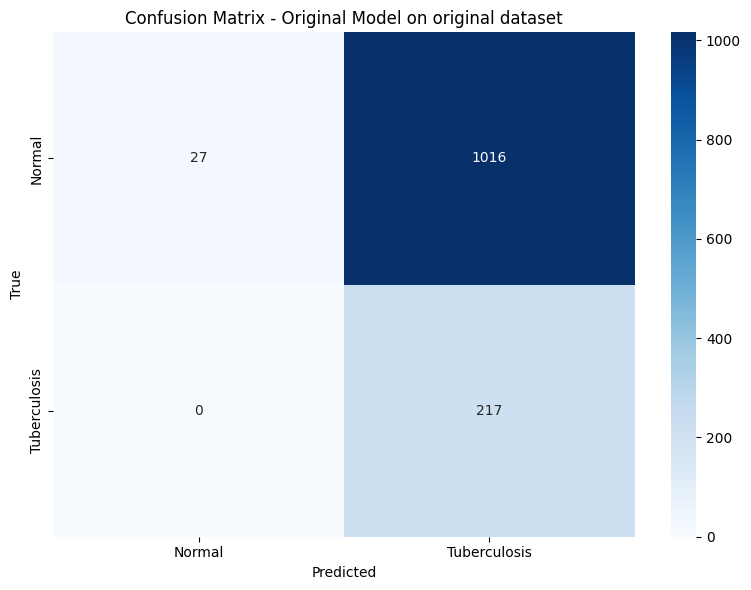

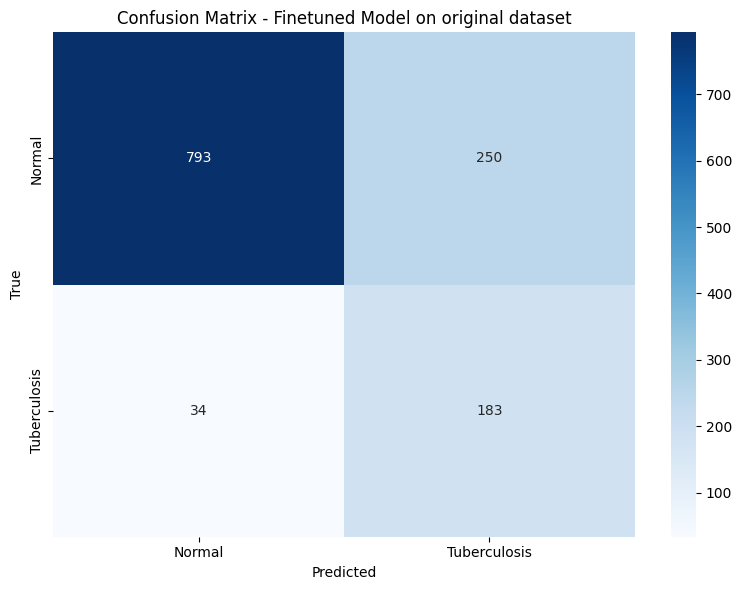

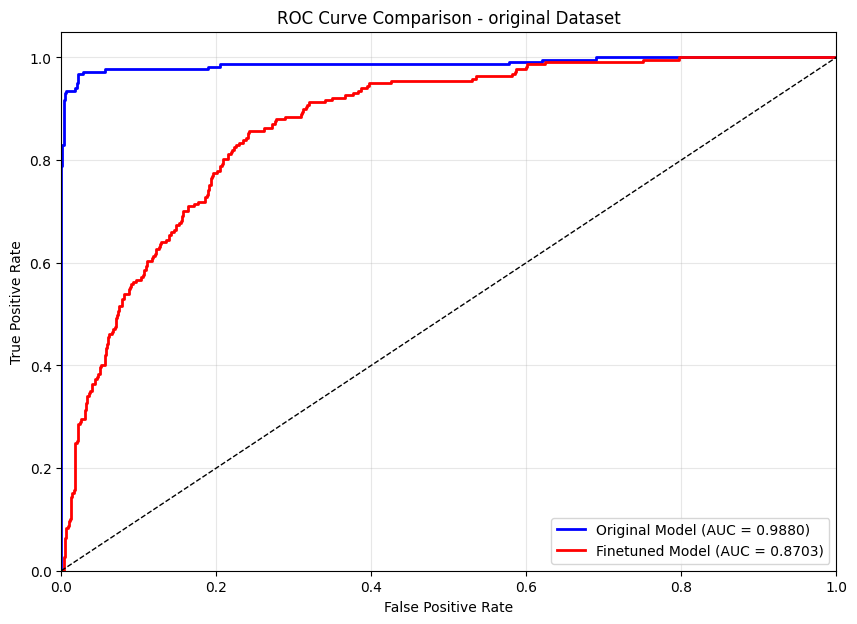


=== Evaluating on feedback dataset ===

Original Model:

--- feedback (Original Model) Dataset Evaluation ---
Accuracy: 0.4167
Precision: 0.4324
Recall: 0.5333
F1 Score: 0.4776
AUC-ROC: 0.3974
Confusion Matrix:
[[ 45 105]
 [ 70  80]]

Finetuned Model:

--- feedback (Finetuned Model) Dataset Evaluation ---
Accuracy: 0.6700
Precision: 0.6947
Recall: 0.6067
F1 Score: 0.6477
AUC-ROC: 0.7588
Confusion Matrix:
[[110  40]
 [ 59  91]]


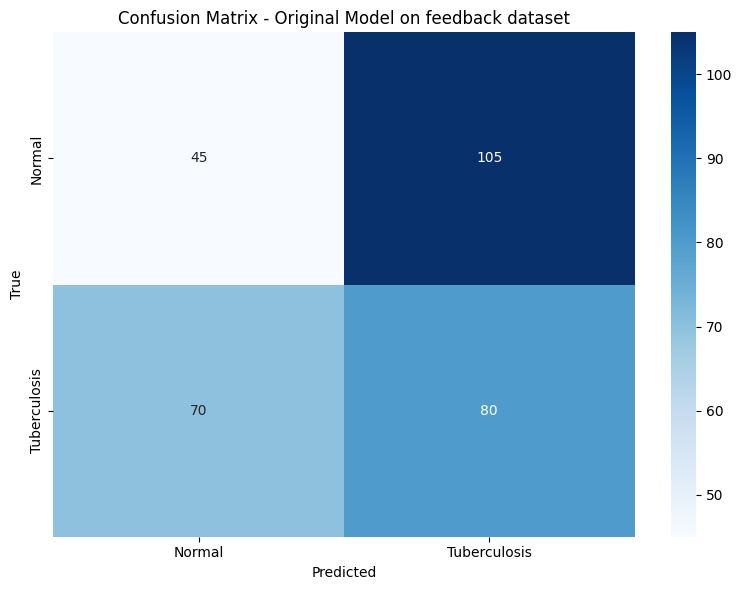

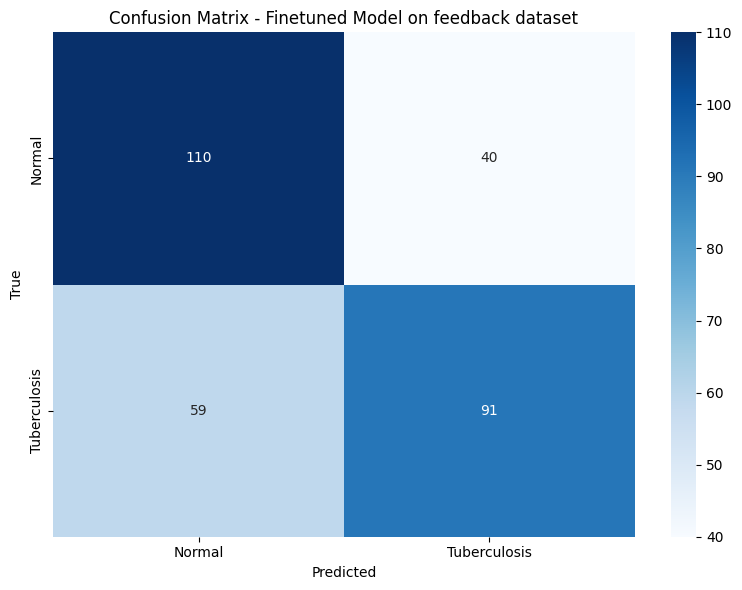

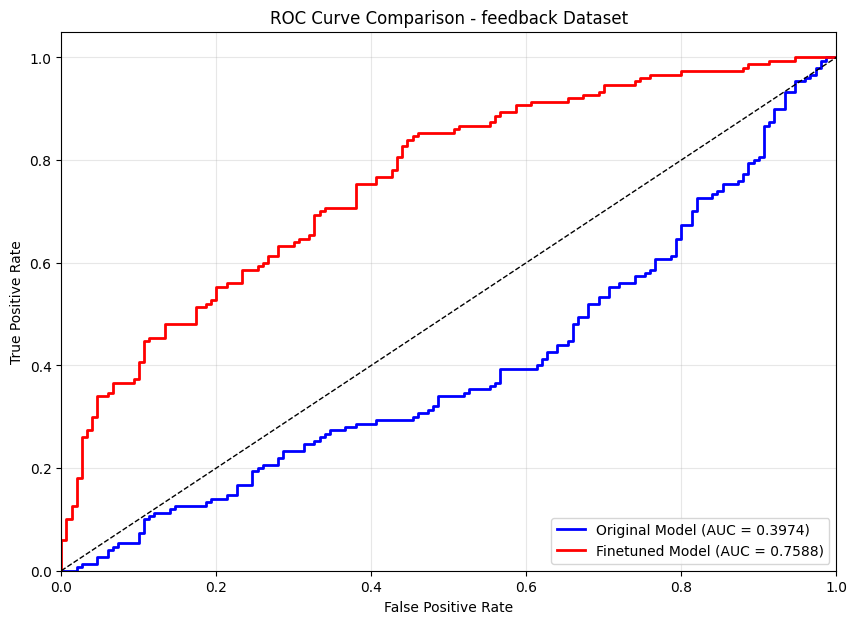


=== Evaluating on new dataset ===

Original Model:

--- new (Original Model) Dataset Evaluation ---
Accuracy: 0.4034
Precision: 0.4176
Recall: 0.5507
F1 Score: 0.4750
AUC-ROC: 0.3832
Confusion Matrix:
[[ 94 265]
 [155 190]]

Finetuned Model:

--- new (Finetuned Model) Dataset Evaluation ---
Accuracy: 0.6932
Precision: 0.7129
Recall: 0.6261
F1 Score: 0.6667
AUC-ROC: 0.7765
Confusion Matrix:
[[272  87]
 [129 216]]


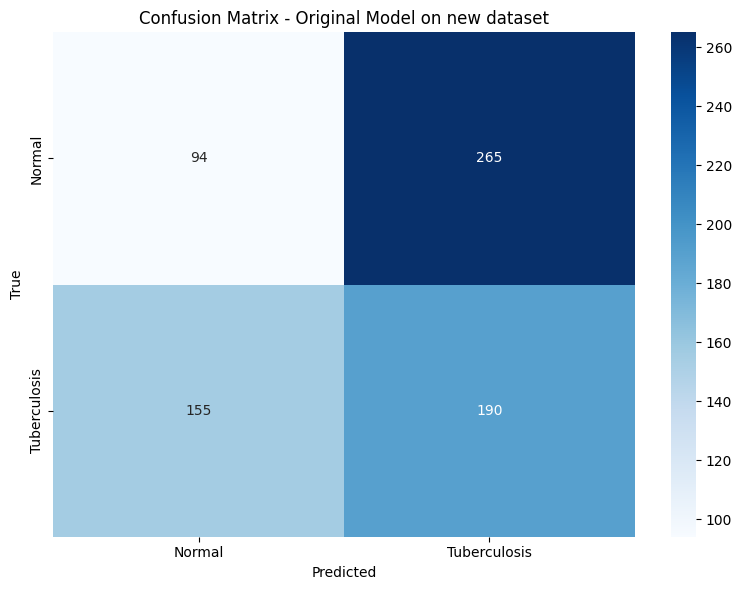

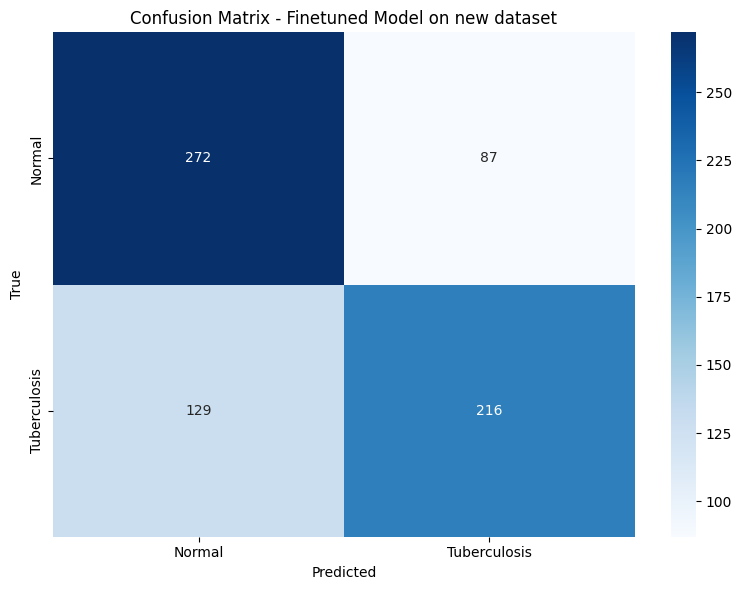

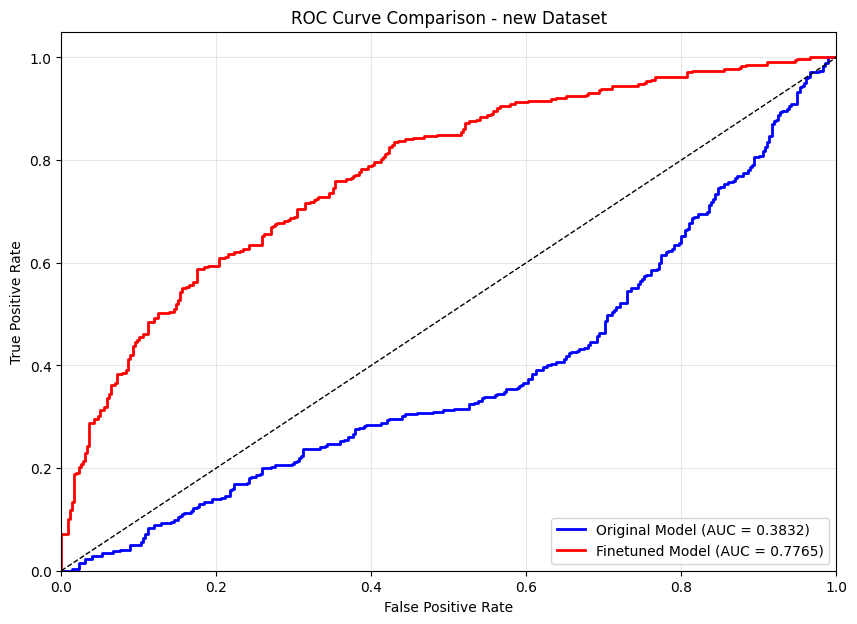

In [6]:
# Evaluate both models on all available datasets
evaluation_results = {}

for dataset_name, dataloader in dataloaders.items():
    print(f"\n=== Evaluating on {dataset_name} dataset ===")
    results = {}
    
    if original_model:
        print("\nOriginal Model:")
        results['original'] = evaluate_model_on_dataset(original_model, dataloader, f"{dataset_name} (Original Model)")
    
    if finetuned_model:
        print("\nFinetuned Model:")
        results['finetuned'] = evaluate_model_on_dataset(finetuned_model, dataloader, f"{dataset_name} (Finetuned Model)")
    
    evaluation_results[dataset_name] = results
    
    # Plot confusion matrices
    if 'original' in results:
        visualize_confusion_matrix(results['original']['metrics']['confusion_matrix'], 
                                  title=f'Confusion Matrix - Original Model on {dataset_name} dataset')
    
    if 'finetuned' in results:
        visualize_confusion_matrix(results['finetuned']['metrics']['confusion_matrix'], 
                                  title=f'Confusion Matrix - Finetuned Model on {dataset_name} dataset')
    
    # Plot ROC curves
    plot_roc_curves(results, dataset_name)